## Universidade Federal do Ceará - Departamento de Engenharia de Teleinformática
### Processamento Digital de Sinais - Técnicas de projeto de filtros digitais

* Filtros seletivos em frequência: admissão e rejeição de componentes de frequências
* O que isso quer dizer?

## Projeto de filtro: passos

1. Especificação das propriedades desejadas;
2. Aproximação das especificações usando um sistema discreto e causal;
3. Realização do sistema.

## Exemplo


Projeto de filtro passa-baixa com frequência de corte $\omega_c$. 

A resposta em frequência ideal com fase linear é dada por:

$$
\begin{equation}
    H_d(e^{j\omega}) = \begin{cases}
        e^{-j\alpha \omega} & |\omega| \leq \omega_c\\
        0 & c.c.
    \end{cases}
\end{equation}
$$

Resposta ao impulso: 

$$
\begin{equation}
    h_d(n) = \frac{\sin(n-\alpha) \omega_c}{\pi (n-a)}, \quad n \in \mathbb{Z}
\end{equation}
$$

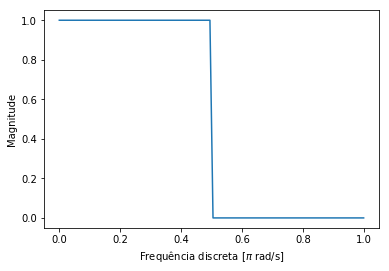

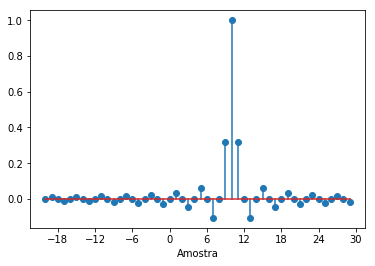

In [1]:


def plot_ideal_freq(wc, alpha):
    w = np.linspace(0, np.pi, 100)
    H = [np.exp(-1j*alpha*wi) if (np.abs(wi) <= wc) else 0 for wi in w]
    
    magH = [ np.abs(Hi)**2 for Hi in H ]
    phaH = [ np.angle(Hi) for Hi in H ]
    plt.figure()
    plt.plot(w/np.pi, magH)
    plt.xlabel('Frequência discreta [$\pi$ rad/s]')
    plt.ylabel('Magnitude')
    
def plot_ideal_tempo(wc, alpha):
    indices = np.arange(-20, 30, 1)
    h = np.zeros((len(indices), 1))
    for n in np.arange(0, len(indices)):
        if indices[n] != alpha:
            h[n] = (np.sin((indices[n] - alpha)*wc))/(np.pi*(indices[n]-alpha))
        else:
            h[n] = 1
        
    plt.figure()
    plt.stem(indices,h)
    plt.xlabel('Amostra')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        

plot_ideal_freq(wc=0.5*np.pi, alpha=10)
plot_ideal_tempo(wc=0.5*np.pi, alpha=10)

## Problemas com esse filtro?

* Não-causal
* Instável

E se o filtro ideal for truncado?

## Janelamento 

A resposta ao impulso ideal é multiplicada por uma janela causal de comprimento $N$ tal que

$h(n) = h_d(n) w(n)$

em que $0 \leq n \leq N-1$.

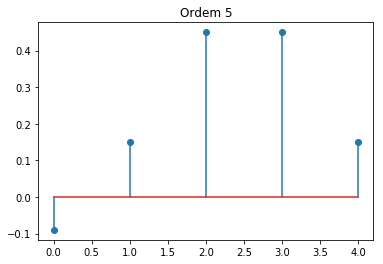

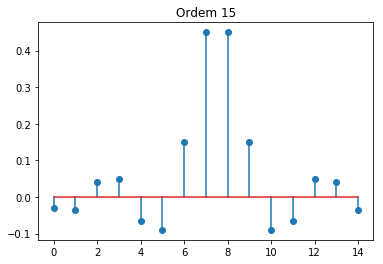

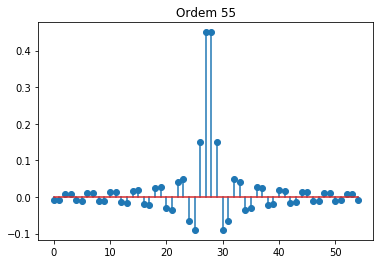

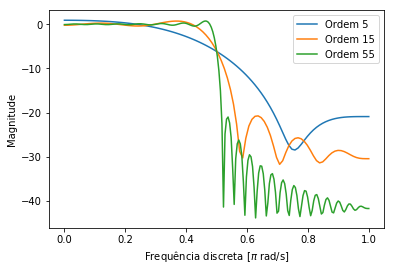

In [2]:
def pb_retangular(N, wc):
    alpha = N/2
    h = np.zeros((N, 1))
    for n in np.arange(N):
        if n != alpha:
            h[n] = (np.sin((n - alpha)*wc))/(np.pi*(n-alpha))
        else:
            h[n] = 1
    return(h)

def calc_freqdomain(h, Nf = 100):
    N = len(h)
    w = np.linspace(0, np.pi, Nf)
    H = np.zeros((Nf,1)) + 1j*np.zeros((Nf,1))
    
    for nf in np.arange(Nf):
        for n in np.arange(N):
            H[nf] += h[n]*np.exp(-1j*n*w[nf]) 
            
    return(H, w)

def plot_freqdomain(H, w, ax = None):
    magH = [ 10*np.log10(np.abs(Hi)**2) for Hi in H ]
    phaH = [ np.angle(Hi) for Hi in H ]
    
    if ax is None:
        plt.figure()
        plt.plot(w/np.pi, magH)
    else:
        ax.plot(w/np.pi, magH)
            
        
h_pb1 = pb_retangular(5, 0.5*np.pi)
(H_pb1, w_pb1) = calc_freqdomain(h_pb1)

h_pb2 = pb_retangular(15, 0.5*np.pi)
(H_pb2, w_pb2) = calc_freqdomain(h_pb2)

h_pb3 = pb_retangular(55, 0.5*np.pi)
(H_pb3, w_pb3) = calc_freqdomain(h_pb3, Nf = 200)

fig = plt.figure()
plt.stem(h_pb1)
plt.title('Ordem 5')

fig = plt.figure()
plt.stem(h_pb2)
plt.title('Ordem 15')

fig = plt.figure()
plt.stem(h_pb3)
plt.title('Ordem 55')

fig = plt.figure()
ax = fig.gca()
plot_freqdomain(H_pb1, w_pb1, ax = ax)
plot_freqdomain(H_pb2, w_pb2, ax = ax)
plot_freqdomain(H_pb3, w_pb3, ax = ax)
plt.xlabel('Frequência discreta [$\pi$ rad/s]')
plt.ylabel('Magnitude')
plt.legend(['Ordem 5', 'Ordem 15', 'Ordem 55'])

## Parâmetros de projeto:

- Oscilação na faixa de passagem
- Oscilação na faixa de rejeitção
- Largura da faixa de transição
- etc.

## Projeto de filtros IIR

- Infinite impulse response (IIR)
- Filtros com retro-alimentação
- Pode ser mais eficiente que filtros com resposta finita ao impulso (FIR)
- Podem ser instáveis (por quê?); cuidado no projeto através de *análise*

Passos

1. Definir requerimentos do filtro: frequência de corte, ripples, etc
2. Obter protótipo analógico do filtro;
3. Determinar coeficientes do filtro IIR a partir do protótipo analógico:


- Invariância do impulso
- Transformação bilinear

## Protótipo de filtros analógicos

Tipos de filtros analógicos:

- Butterworth
- Chebyshev tipo I
- Chebyshev tipo II
- Elíptico

Para cada tipo de filtro, há um procedimento para a obtenção dos polos e zeros

Isso permite construir a função de transferência do filtro analógico protótipo

Em seguida, é preciso obter os coeficientes dos filtros **digitais**


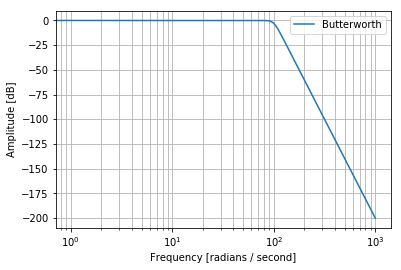

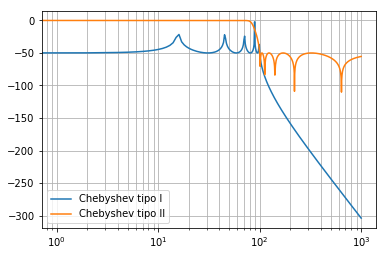

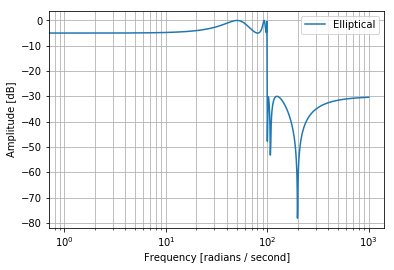

In [8]:
from scipy import signal

w = np.linspace(0, 1e3, 1000)

ordem = 10
ripple = 50 # dB
ripple_el_p = 5 # dB
ripple_el_s = 30 # dB
freqcorte = 100

# Butterworth
b_butter, a_butter = signal.butter(ordem, freqcorte, 'low', analog=True)
w_butter, h_butter = signal.freqs(b_butter, a_butter, worN=w)

# Chebyshev tipo I
b_ch1, a_ch1 = signal.cheby1(ordem, ripple, freqcorte, 'low', analog=True)
w_ch1, h_ch1 = signal.freqs(b_ch1, a_ch1, worN=w)

# Chebyshev tipo II
b_ch2, a_ch2 = signal.cheby2(ordem, ripple, freqcorte, 'low', analog=True)
w_ch2, h_ch2 = signal.freqs(b_ch2, a_ch2, worN=w)

b_el, a_el = signal.ellip(ordem, ripple_el_p, ripple_el_s, freqcorte, 'low', analog=True)
w_el, h_el = signal.freqs(b_el, a_el, worN=w)

plt.figure()
plt.semilogx(w, 20 * np.log10(abs(h_butter)))
plt.grid(which='both', axis='both')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.legend(['Butterworth'])

plt.figure()
plt.grid(which='both', axis='both')
plt.semilogx(w, 20 * np.log10(abs(h_ch1)))
plt.semilogx(w, 20 * np.log10(abs(h_ch2)))
plt.legend(['Chebyshev tipo I', 'Chebyshev tipo II'])

plt.figure()
plt.grid(which='both', axis='both')
plt.semilogx(w, 20 * np.log10(abs(h_el)))
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.legend(['Elliptical'])

## Projeto de filtros IIR pela técnica da invariância do impulso

## Projeto de filtros IIR pela técnica da transformação bilinear

## Exemplos de projetos de filtros

## Trabalho computacional